In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, Normalizer
from sklearn.model_selection import cross_val_score, cross_validate
from xgboost import XGBRegressor
import seaborn as sns

C:\Users\Wynns\anaconda3\envs\workspace\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Read Files and PreProcess

In [2]:
df = pd.read_csv(r'./train.csv')
df_test = pd.read_csv(r'./test.csv')

# Preprocess department
print("Preprocess department\n""BEFORE:")
print(df.department.value_counts())
print(df_test.department.value_counts())
df=df.replace(['finishing '], ['finishing']) # 去除多餘空格
df_test=df_test.replace(['finishing '], ['finishing']) # 去除多餘空白
print("---------------------\nAFTER:")
print(df.department.value_counts())
print(df_test.department.value_counts())

# PreProcess wip
print("=====================")
print("Preprocess wip\n""BEFORE:")
print(df.isna().sum())
print(df_test.isna().sum())
df['wip'].fillna(0,inplace=True) # 空白處填 0
df_test['wip'].fillna(0,inplace=True) # 空白處填 0
print("---------------------\nAFTER:")
print(df.isna().sum())
print(df_test.isna().sum())

Preprocess department
BEFORE:
sweing        561
finishing     257
finishing     139
Name: department, dtype: int64
sweing       130
finishing    110
Name: department, dtype: int64
---------------------
AFTER:
sweing       561
finishing    396
Name: department, dtype: int64
sweing       130
finishing    110
Name: department, dtype: int64
Preprocess wip
BEFORE:
date                       0
quarter                    0
department                 0
day                        0
team                       0
targeted_productivity      0
smv                        0
wip                      396
over_time                  0
incentive                  0
idle_time                  0
idle_men                   0
no_of_style_change         0
no_of_workers              0
actual_productivity        0
dtype: int64
date                       0
quarter                    0
department                 0
day                        0
team                       0
targeted_productivity      0
smv             

Adding Feature

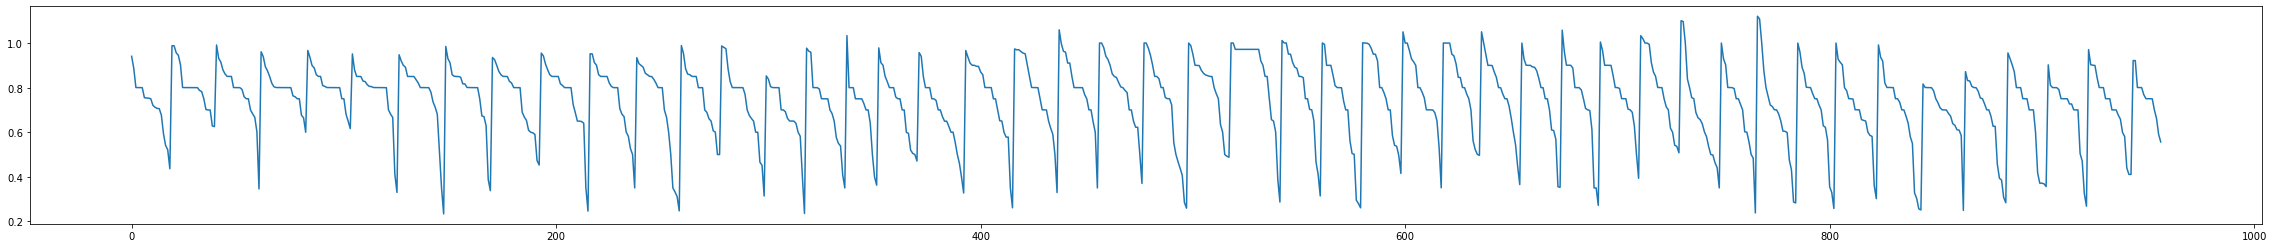

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,rule
0,2/26/2015,Quarter4,sweing,Thursday,4,0.80,30.10,437.0,7080,32,0.0,0,2,59,15
1,2/26/2015,Quarter4,sweing,Thursday,5,0.35,27.48,413.0,6840,38,0.0,0,1,57,16
2,2/26/2015,Quarter4,finishing,Thursday,10,0.70,2.90,0.0,3360,0,0.0,0,0,8,17
3,2/26/2015,Quarter4,finishing,Thursday,9,0.75,2.90,0.0,960,0,0.0,0,0,8,18
4,2/26/2015,Quarter4,sweing,Thursday,1,0.35,26.66,1164.0,6600,23,0.0,0,2,55,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,3/11/2015,Quarter2,finishing,Wednesday,10,0.75,2.90,0.0,960,0,0.0,0,0,8,20
236,3/11/2015,Quarter2,finishing,Wednesday,8,0.70,3.90,0.0,960,0,0.0,0,0,8,21
237,3/11/2015,Quarter2,finishing,Wednesday,7,0.65,3.90,0.0,960,0,0.0,0,0,8,22
238,3/11/2015,Quarter2,finishing,Wednesday,9,0.75,2.90,0.0,1800,0,0.0,0,0,15,23


In [8]:
# Finding feature
fig=plt.figure()
plt.plot(df['actual_productivity'])
plt.rcParams["figure.figsize"] = (16, 4)
fig.set_figheight(4)
fig.set_figwidth(40)
plt.show()

# Adding column for the special pattern
count=1
temp_date=1
temp_array=[]
for i in df.index:
    if temp_date!=df['date'][i]:
        temp_array.append(1)
        count=2
        temp_date=df['date'][i]
    else:
        temp_array.append(count)
        count+=1
df['rule']=temp_array
count=1
temp_date=1
temp_array=[]
for i in df_test.index:
    if temp_date!=df_test['date'][i]:
        temp_array.append(1)
        count=2
        temp_date=df_test['date'][i]
    else:
        temp_array.append(count)
        count+=1
countForFeb26=15
for j in df_test.index:
    if df_test['date'][j]=="2/26/2015":
        temp_array[j]=countForFeb26
        countForFeb26+=1
df_test['rule']=temp_array

Others Data PreProcess

In [9]:
# One Hot Encoding for categorical columns
def create_dummies(dataframe, column_name):
    dummies = pd.get_dummies(dataframe[column_name], prefix=column_name)
    dataframe = pd.concat([dataframe, dummies], axis=1)
    return dataframe

df = create_dummies(df,"quarter")
df = create_dummies(df,"department")
df = create_dummies(df,"day")
df = create_dummies(df,"team")
df_test = create_dummies(df_test,"quarter")
df_test = create_dummies(df_test,"department")
df_test = create_dummies(df_test,"day")
df_test = create_dummies(df_test,"team")
df=df.drop(['quarter', 'department', 'day', 'team'],axis=1)
df_test=df_test.drop(['quarter', 'department', 'day', 'team'],axis=1)

# Labeling
le = LabelEncoder()
df["no_of_style_change"] = le.fit_transform(df["no_of_style_change"])
df['date'] = le.fit_transform(df['date'])
df_test["no_of_style_change"] = le.fit_transform(df_test["no_of_style_change"])
df_test['date'] = le.fit_transform(df_test['date'])

# Final Adjustment
df = df.reindex(sorted(df.columns), axis=1)
y = df['actual_productivity']
X = df.loc[:, df.columns != 'actual_productivity']
df_test['quarter_Quarter3'], df_test['quarter_Quarter5']=0,0
df_test = df_test.reindex(sorted(df_test.columns), axis=1)
X_test = df_test[df_test.columns]

# Numerical Variable
scaler = MinMaxScaler()
# scaler = Normalizer()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.fit_transform(X_test)

,date,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,department_finishing,department_sweing,idle_men,...,team_12,team_2,team_3,team_4,team_5,team_6,team_7,team_8,team_9,wip
0,0,0,0,0,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,437.0
1,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,413.0
2,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.0
3,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0.0
4,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1164.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,4,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0.0
236,4,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0.0
237,4,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,0.0
238,4,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0.0


Tuning Model

In [ ]:
from sklearn.model_selection import GridSearchCV

params = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1, 0.3],
           'n_estimators': [100, 500, 1000],
           'colsample_bytree': [0.5, 0.7, 0.9],
           'subsample': [0.6, 0.8, 1.0]}
xgbr = XGBRegressor(seed = 20)
clf = GridSearchCV(estimator=xgbr,
                   param_grid=params,
                   scoring='neg_mean_squared_error',
                   verbose=1)
clf.fit(X_scaled, y)
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


Training and Testing

R2: 0.0816 (std: 0.0052)
R2: 0.7569 (std: 0.0911)
MSE: 0.0067 (std: 0.0009)
MAPE: 0.0985 (std: 0.0057)


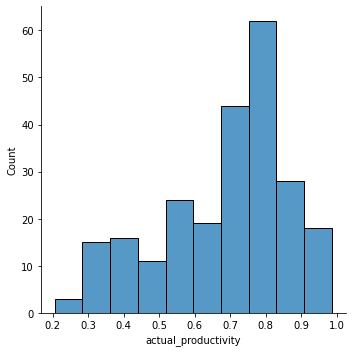

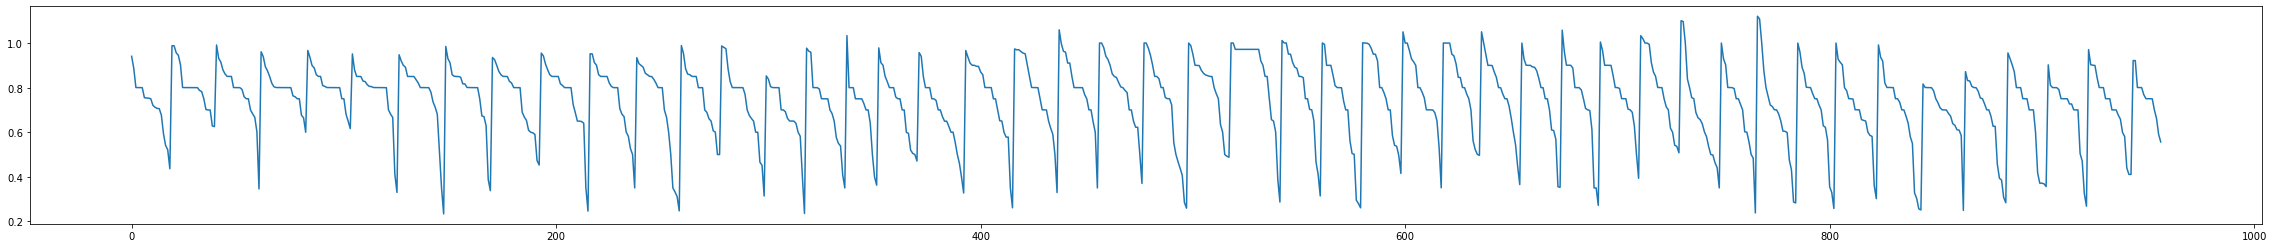

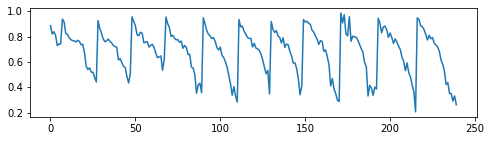

In [28]:
# Training with XGBoost
xgb=XGBRegressor(max_depth=6,
                 colsample_bytree=0.6,
                 min_child_weight=3.0,
                 n_estimators=500,
                 learning_rate=.05,
                 objective='reg:squarederror')
score = np.sqrt(-cross_val_score(xgb, X_scaled, y, cv = 5, scoring = 'neg_mean_squared_error'))
print("R2: %0.4f (std: %0.4f)" % (score.mean(), score.std()))
scores = cross_validate(xgb, X_scaled, y, cv=5, scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error'))
print("====================================")
print("R2: %0.4f (std: %0.4f)" % (scores['test_r2'].mean(), scores['test_r2'].std()))
print("MSE: %0.4f (std: %0.4f)" % (-scores['test_neg_mean_squared_error'].mean(), scores['test_neg_mean_squared_error'].std()))
print("MAPE: %0.4f (std: %0.4f)" % (-scores['test_neg_mean_absolute_percentage_error'].mean(), scores['test_neg_mean_absolute_percentage_error'].std()))

# Predict test data
xgb.fit(X_scaled, y)
y_pred = xgb.predict(X_test_scaled)

# Visualization and Output CSV
df_ans = pd.DataFrame(y_pred.astype(float), columns=['actual_productivity'])
df_ans.to_csv('mySubmission.csv', index_label='Id')
sns.displot(df_ans['actual_productivity'])
fig=plt.figure()
plt.plot(df['actual_productivity'])
plt.rcParams["figure.figsize"] = (16, 4)
fig.set_figheight(4)
fig.set_figwidth(40)
plt.show()
plt.rcParams["figure.figsize"] = (8, 2)
fig.set_figheight(2)
fig.set_figwidth(10)
plt.plot(df_ans)
plt.show()